**This notebook shows how to read from a "zarr" dataset, which has been "chunked" (broken into a little bits) in a way that makes grabbing a time series from a single point very quickly.**

The essence is that while the original data was many raster files, each file representing imagery from a single timestamp, the "zarr" dataset is stored in time series, so there is a single file for each pixel and all the values in time belonging to that pixel (actually, the files are 3x3 pixels).

In [1]:
import xarray as xr
import glob
import os
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
from dask.distributed import Client, LocalCluster


### Start a Dask Cluster 

In [2]:
# Create a Dask cluster so we can watch the dask dashboard
workers = 6
ip_addres = 'http://j-lundquist-3.ce.washington.edu'
port=':8787'
threads = 2
cluster = LocalCluster(n_workers=workers, threads_per_worker=threads, dashboard_address=port)
client = Client(cluster)

### Open all raster files from zarr

In [3]:
zarr_path = '/storage/GOES/orthorectified/Fog2022_withtime.zarr'
ds = xr.open_dataset(
    zarr_path,
    chunks={'time': 40785, 'latitude': 10, 'longitude': 10},
    engine='zarr'
)
# When we pass in a chunks argument, the dataset opened will be filled with Dask arrays

/home/ngoc54n/miniconda3/envs/goesenv/lib/python3.11/site-packages/xarray/core/dataset.py:247: UserWarning: The specified Dask chunks separate the stored chunks along dimension "latitude" starting at index 10. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/home/ngoc54n/miniconda3/envs/goesenv/lib/python3.11/site-packages/xarray/core/dataset.py:247: UserWarning: The specified Dask chunks separate the stored chunks along dimension "longitude" starting at index 10. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


In [4]:
ds # reanme HT?

<xarray.Dataset>
Dimensions:      (time: 40785, latitude: 284, longitude: 284)
Coordinates:
  * latitude     (latitude) float64 49.0 48.99 48.98 48.97 ... 46.03 46.02 46.01
  * longitude    (longitude) float64 -125.0 -125.0 -125.0 ... -122.0 -122.0
  * time         (time) datetime64[ns] 2022-05-01T00:01:17 ... 2022-10-01T00:...
Data variables:
    HT           (time, latitude, longitude) float32 dask.array<chunksize=(40785, 10, 10), meta=np.ndarray>
    spatial_ref  (time) int64 dask.array<chunksize=(40785,), meta=np.ndarray>

In [5]:
ds['HT']

<xarray.DataArray 'HT' (time: 40785, latitude: 284, longitude: 284)>
dask.array<open_dataset-2a64c54798bf7e238b661394f94300f9HT, shape=(40785, 284, 284), dtype=float32, chunksize=(40785, 10, 10), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 49.0 48.99 48.98 48.97 ... 46.03 46.02 46.01
  * longitude  (longitude) float64 -125.0 -125.0 -125.0 ... -122.0 -122.0 -122.0
  * time       (time) datetime64[ns] 2022-05-01T00:01:17 ... 2022-10-01T00:01:17
Attributes:
    coordinates:   dem_px_angle_y dem_px_angle_x
    grid_mapping:  spatial_ref

### Get the datetimes from the file names to replace the time index in the dataset
because zarr has a bug that does not allow it to save `datetime64[ns]` objects correctly (precision is lost for hours and minutes)

In [6]:
image_folder = '/storage/GOES/orthorectified/Fog2022_withtime/'
files = glob.glob(os.path.join(image_folder, "*_o.nc"))
files[0] # Take a look at the path of one file

'/storage/GOES/orthorectified/Fog2022_withtime/OR_ABI-L2-ACHAC-M6_G17_s20222440001177_e20222440003550_c20222440007138_o.nc'

In [7]:
datetimes = [
    dt.datetime.strptime(
        f.split('_')[4][1:-1], # parse the start time (the part "s2022__________" in the file name)
        "%Y%j%H%M%S"
    ) for f in files
]
''' The files in zarr are already sorted chronologically, 
but the files in the image_folder directory are not, 
so the datetimes info parsed from the directory also have to be sorted.'''
datetimes = sorted(datetimes)

In [8]:
ds['time'] = datetimes

In [9]:
# Take a look at the datetime objects
pd.to_datetime(ds['time'])

DatetimeIndex(['2022-05-01 00:01:17', '2022-05-01 00:06:17',
               '2022-05-01 00:11:17', '2022-05-01 00:16:17',
               '2022-05-01 00:21:17', '2022-05-01 00:26:17',
               '2022-05-01 00:31:17', '2022-05-01 00:36:17',
               '2022-05-01 00:41:17', '2022-05-01 00:46:17',
               ...
               '2022-09-30 23:06:17', '2022-09-30 23:11:17',
               '2022-09-30 23:16:17', '2022-09-30 23:21:17',
               '2022-09-30 23:26:17', '2022-09-30 23:31:17',
               '2022-09-30 23:36:17', '2022-09-30 23:41:17',
               '2022-09-30 23:46:17', '2022-09-30 23:51:17'],
              dtype='datetime64[ns]', length=40785, freq=None)

### Let's look at the time series at a single point, for 6 days

In [10]:
falsebay_timeseries = ds['HT'].sel(latitude = 48.490914, longitude = -123.069227, method='nearest')

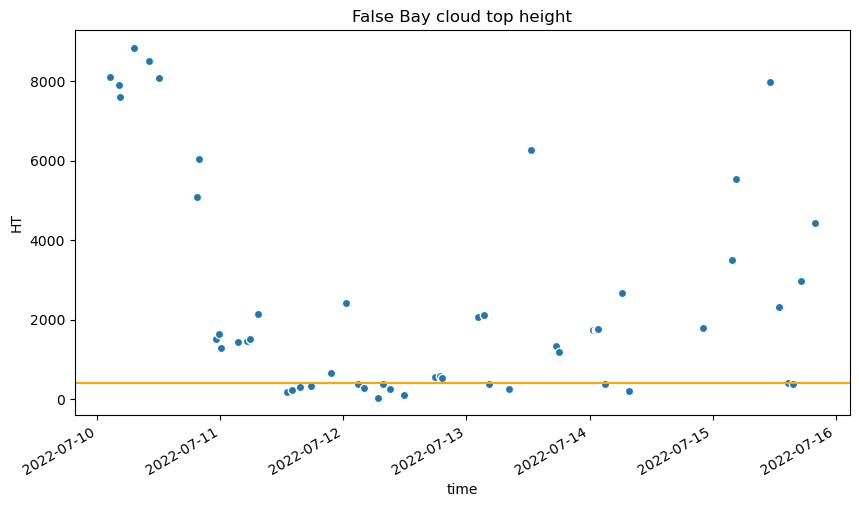

In [11]:
plt.figure(figsize = (10,5))
falsebay_timeseries.sel(time = slice('July 10, 2022', 'July 15, 2022')).plot.scatter('time')
plt.title('False Bay cloud top height')
plt.axhline(400, color='orange') # 400 meters is the chosen threshold for low cloud and fog

In [12]:
# Longitudes and Latitudes for all the field locations on San Juan Islands
pt1 = [48.50891,        -123.03491]
pt2 = [48.55745,        -123.0824]
pt3 = [48.52329,        -123.1371]
pt4 = [40.55423,        -122.36151]
pt5 = [48.46446,        -122.96222]
pt6 = [48.53304291, 	-123.0882645]
pt7 = [48.61820602, 	-123.1203384]
pt8 = [48.56717682, 	-123.1648407]
pt9 = [48.48910141, 	-123.0627441]
pt10 = [48.48910141, 	-123.0627441]
pt11 = [48.490756, 	    -123.067895]
pt12 = [48.57880161, 	-123.1731671]

### Calculate fog frequency

In [13]:
# We choose 400 meters as the threshold for cloud top height to be considered fog or low cloud
ds['FLCC'] = (ds['HT'] < 400).astype(int)

In [14]:
ds["HT"].values # Take over a minute to run!? Only to show all nan values??

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

In [15]:
# documentation about indexing using datetime components: https://docs.xarray.dev/en/stable/user-guide/time-series.html#indexing-using-datetime-components
# Select images taken from 5am to the end of 9am for see fog frequency in the morning
morning_ds = ds.isel(time=ds.time.dt.hour.isin([5,6,7,8,9])) 
# Select images taken from 11am to the end of 12pm for see fog frequency during midday
midday_ds = ds.isel(time=ds.time.dt.hour.isin([11,12]))
# Select images taken from 1pm to the end of 5pm for see fog frequency in the afternoon
afternoon_ds = ds.isel(time=ds.time.dt.hour.isin([1,2,3,4,5]))

In [16]:
FLCC_freq = (
    ds['FLCC'].sum(dim='time') / ds['time'].size
)
FLCC_freq 
# Because we are working with Dask arrays in this dataset, frequency data won't actually be calculated until .load() is called in the cell below. The output of this cell is just a preview of what FLCC_freq will look like,

<xarray.DataArray 'FLCC' (latitude: 284, longitude: 284)>
dask.array<truediv, shape=(284, 284), dtype=float64, chunksize=(10, 10), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 49.0 48.99 48.98 48.97 ... 46.03 46.02 46.01
  * longitude  (longitude) float64 -125.0 -125.0 -125.0 ... -122.0 -122.0 -122.0

In [17]:
# We call load to get this in memory right away - then plotting doesn't take a long time.
FLCC_freq.load()

<xarray.DataArray 'FLCC' (latitude: 284, longitude: 284)>
array([[2.45188182e-05, 2.45188182e-05, 2.45188182e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.45188182e-05, 2.45188182e-05, 2.45188182e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.45188182e-05, 2.45188182e-05, 2.45188182e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [4.60953782e-03, 4.60953782e-03, 4.60953782e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.60953782e-03, 4.60953782e-03, 4.60953782e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.60953782e-03, 4.60953782e-03, 4.60953782e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])
Coordinates:
  * latitude   (latitude) float64 49.0 48.99 48.98 48.97 ... 46.03 46.02 46.01
  * longitude  (longitude) float64 -125.0 -125.0 -125.0 ... -122.0 -122.0 -122.0

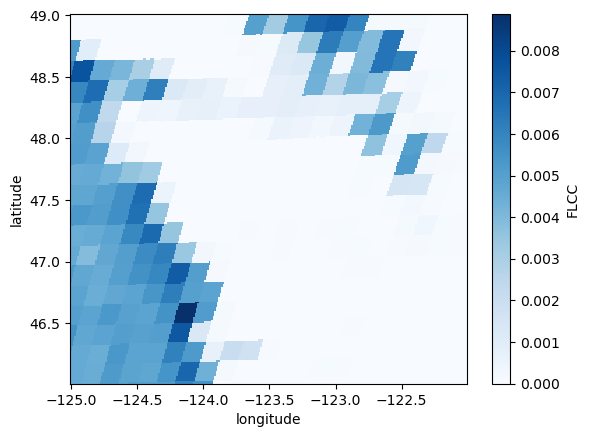

In [18]:
FLCC_freq.plot(cmap = 'Blues') # remove vmax = 0.3??

In [19]:
morning_freq = (
    morning_ds['FLCC'].sum(dim='time') / morning_ds['time'].size
)

In [20]:
morning_freq.load()

<xarray.DataArray 'FLCC' (latitude: 284, longitude: 284)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00457761, 0.00457761, 0.00457761, ..., 0.        , 0.        ,
        0.        ],
       [0.00457761, 0.00457761, 0.00457761, ..., 0.        , 0.        ,
        0.        ],
       [0.00457761, 0.00457761, 0.00457761, ..., 0.        , 0.        ,
        0.        ]])
Coordinates:
  * latitude   (latitude) float64 49.0 48.99 48.98 48.97 ... 46.03 46.02 46.01
  * longitude  (longitude) float64 -125.0 -125.0 -125.0 ... -122.0 -122.0 -122.0

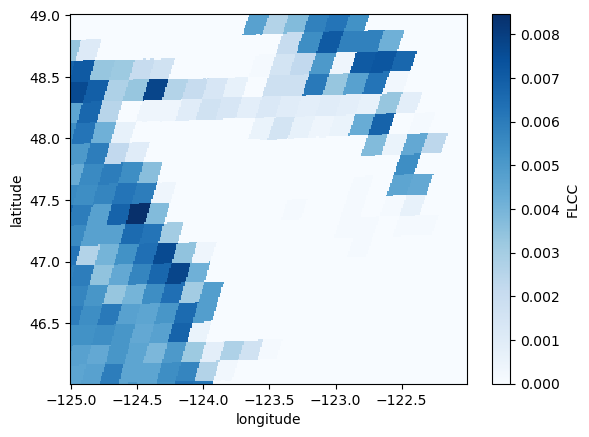

In [22]:
morning_freq.plot(cmap = 'Blues')